In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
# sober x,y方向的卷积核
K_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])
K_y = K_x.T

In [4]:
def corr2d(X: np.ndarray, K: np.ndarray, padding_same=False) -> np.ndarray:
    """二维互相关运算

    Args:
        X (np.ndarray): 原图 [H, W]
        K (np.ndarray): 卷积核 [K_H, K_W]
        padding_same (bool, optional): 是否padding为原图大小. Defaults to False.

    Returns:
        np.ndarray: 互相关结果 [H, W]
    """
    X_ = X.copy()
    h, w = K.shape
    if padding_same:
        pad_width = [(h//2, h//2), (w//2, w//2)]
        X_ = np.pad(X_, pad_width=pad_width, mode="constant", constant_values=0)
    Y = np.zeros((X_.shape[0] - h + 1, X_.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X_[i:i + h, j:j + w] * K).sum()
    return Y

In [5]:
def sober(X: np.ndarray, K: np.ndarray):
    conv_result = corr2d(X.astype(np.float32), K.astype(np.float32), padding_same=True)
    clip_result = np.clip(conv_result, 0, 255)
    return clip_result.astype(np.uint8)

# read image

(612, 612)


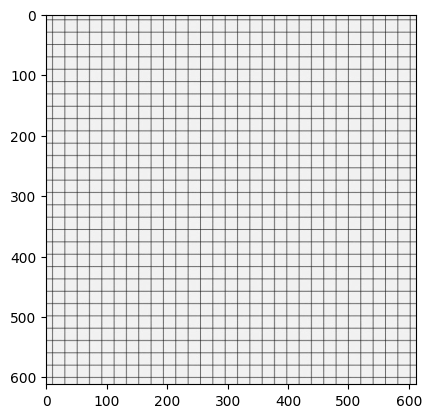

In [6]:
image = cv2.imread("../images/line.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(image, cmap="gray")

# x(去除x方向直线)

[[255   0   0 ...   0   0   0]
 [255   0   0 ...   0   0   0]
 [255   0   0 ...   0   0   0]
 ...
 [255   0   0 ...   2   2   0]
 [255   0   0 ...   0   0   0]
 [255   0   0 ...   0   0   0]]


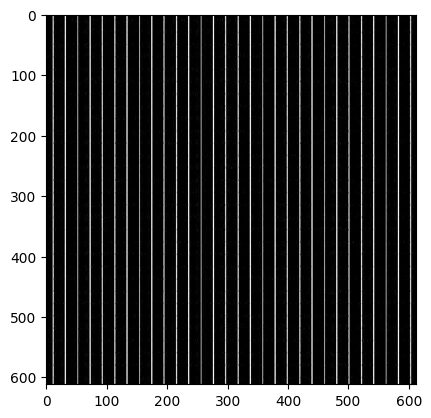

In [7]:
Gx_1 = cv2.Sobel(
    src=image,
    ddepth=-1,  # 输出图像深度
    dx=1,       # X方向，几阶导数
    dy=0,       # Y方向，几阶导数
    ksize=3,    # SOBEL算子kernel大小，必须是奇数
    scale=1,
    delta=0,
    borderType=cv2.BORDER_CONSTANT,
)
print(Gx_1)
plt.imshow(Gx_1, cmap="gray")

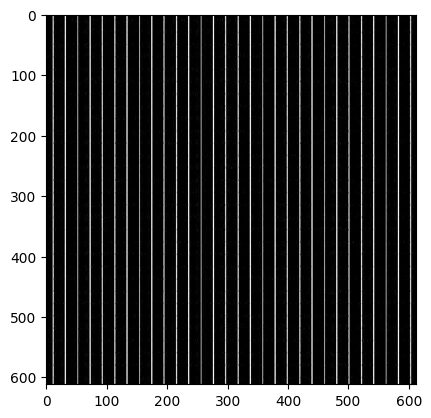

In [8]:
plt.imshow(cv2.convertScaleAbs(Gx_1), cmap="gray")

[[255   0   0 ...   0   0   0]
 [255   0   0 ...   0   0   0]
 [255   0   0 ...   0   0   0]
 ...
 [255   0   0 ...   2   2   0]
 [255   0   0 ...   0   0   0]
 [255   0   0 ...   0   0   0]]


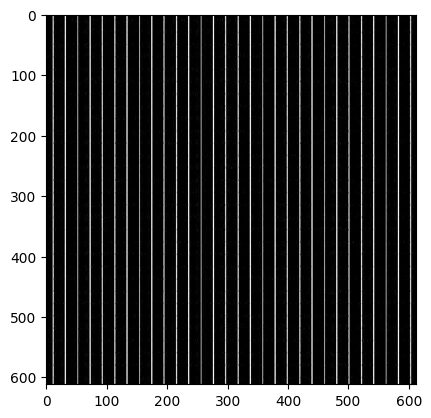

In [9]:
Gx_2 = sober(image, K_x)
print(Gx_2)
plt.imshow(Gx_2, cmap="gray")

In [10]:
# 复现成功
np.all(Gx_1 == Gx_2)

True

# y(去除y方向直线)

[[255 255 255 ... 255 255 255]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   1   2 ...   0   0   0]
 [  0   1   3 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


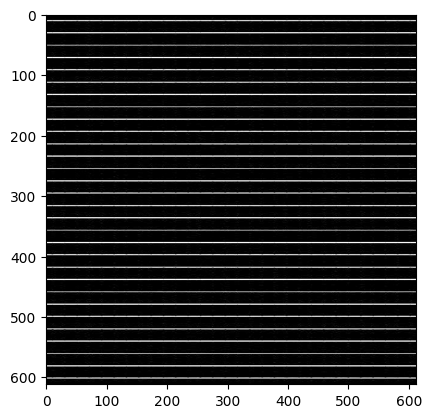

In [11]:
Gy_1 = cv2.Sobel(
    src=image,
    ddepth=-1,  # 输出图像深度
    dx=0,       # X方向，几阶导数
    dy=1,       # Y方向，几阶导数
    ksize=3,    # SOBEL算子kernel大小，必须是奇数
    scale=1,
    delta=0,
    borderType=cv2.BORDER_CONSTANT,
)
print(Gy_1)
plt.imshow(Gy_1, cmap="gray")

[[255 255 255 ... 255 255 255]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   1   2 ...   0   0   0]
 [  0   1   3 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


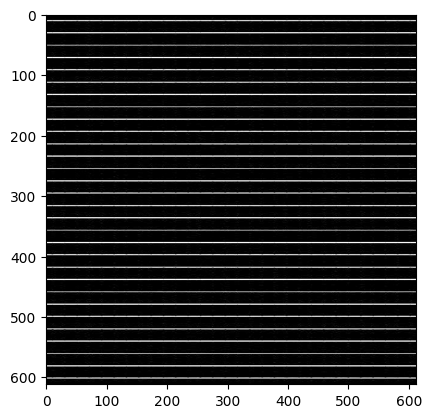

In [12]:
Gy_2 = sober(image, K_y)
print(Gy_2)
plt.imshow(Gy_2, cmap="gray")

In [13]:
# 复现成功
np.all(Gy_1 == Gy_2)

True

# xy

[[241   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   1]
 [  0   1   1 ...   0   0   2]
 [  0   0   1 ...   0   0 241]]


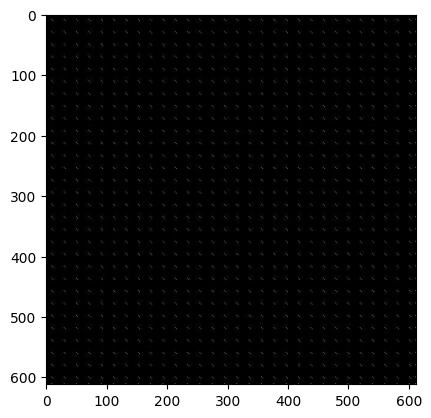

In [14]:
Gxy_1 = cv2.Sobel(
    src=image,
    ddepth=-1,  # 输出图像深度
    dx=1,       # X方向，几阶导数
    dy=1,       # Y方向，几阶导数
    ksize=3,    # SOBEL算子kernel大小，必须是奇数
    scale=1,
    delta=0,
    borderType=cv2.BORDER_CONSTANT,
)
print(Gxy_1)
plt.imshow(Gxy_1, cmap="gray")

In [15]:
add1 = cv2.addWeighted(Gx_2, 0.5, Gy_2, 0.5, 0)
add1

array([[255, 128, 128, ..., 128, 128, 128],
       [128,   0,   0, ...,   0,   0,   0],
       [128,   0,   0, ...,   0,   0,   0],
       ...,
       [128,   0,   1, ...,   1,   1,   0],
       [128,   0,   2, ...,   0,   0,   0],
       [128,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [16]:
# 需要四舍五入
add2 = (Gx_2 * 0.5 + Gy_2 * 0.5).round().astype(np.uint8)
add2

array([[255, 128, 128, ..., 128, 128, 128],
       [128,   0,   0, ...,   0,   0,   0],
       [128,   0,   0, ...,   0,   0,   0],
       ...,
       [128,   0,   1, ...,   1,   1,   0],
       [128,   0,   2, ...,   0,   0,   0],
       [128,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [17]:
np.all(add1 == add2)

True

In [18]:
# 没有用numpy实现对应的 xy

# 计算梯度幅度

[ 0.          0.06262243  0.06696495 ... 15.96871942         inf
         nan]
[[ 1.  0.  0. ...  0.  0.  0.]
 [inf nan nan ... nan nan nan]
 [inf nan nan ... nan nan nan]
 ...
 [inf  0.  0. ... inf inf nan]
 [inf  0.  0. ... nan nan nan]
 [inf nan nan ... nan nan nan]]


C:\Users\Frostbite\AppData\Local\Temp\ipykernel_16244\1090935661.py:1: RuntimeWarning: divide by zero encountered in divide
  magnitude = np.sqrt(Gx_1 / Gy_1)
C:\Users\Frostbite\AppData\Local\Temp\ipykernel_16244\1090935661.py:1: RuntimeWarning: invalid value encountered in divide
  magnitude = np.sqrt(Gx_1 / Gy_1)


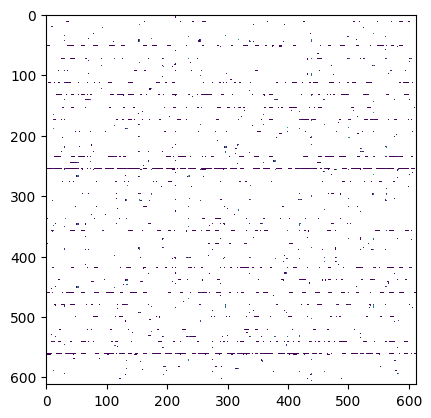

In [19]:
magnitude = np.sqrt(Gx_1 / Gy_1)
print(np.unique(magnitude))
print(magnitude)
plt.imshow(magnitude)

[ 0.     1.     1.414  1.732  2.     2.236  2.45   2.646  2.828  3.
  3.162  3.316  3.465  3.605  3.742  3.873  4.     4.125  4.242  4.36
  4.473  4.582  4.69   4.797  4.9    5.     5.098  5.195  5.293  5.387
  5.477  5.566  5.656  5.746  5.832  5.918  6.     6.082  6.164  6.246
  6.324  6.402  6.48   6.56   6.633  6.707  6.78   6.855  6.93   7.
  7.07   7.14   7.21   7.28   7.348  7.418  7.484  7.55   7.617  7.68
  7.746  7.81   7.875  7.938  8.     8.06   8.125  8.19   8.25   8.305
  8.37   8.43   8.484  8.55   8.6    8.664  8.72   8.77   8.83   8.89
  8.945  9.     9.055  9.11   9.164  9.22   9.27   9.33   9.38   9.44
  9.484  9.54   9.59   9.64   9.695  9.75   9.8    9.85   9.9    9.95
 10.    10.05  10.1   10.15  10.195 10.25  10.3   10.34  10.39  10.44
 10.484 10.54  10.586 10.63  10.68  10.73  10.77  10.82  10.86  10.91
 10.95  11.    11.05  11.09  11.13  11.18  11.23  11.266 11.31  11.36
 11.4   11.445 11.49  11.53  11.58  11.62  11.664 11.7   11.75  11.79
 11.836 11.875 11.914

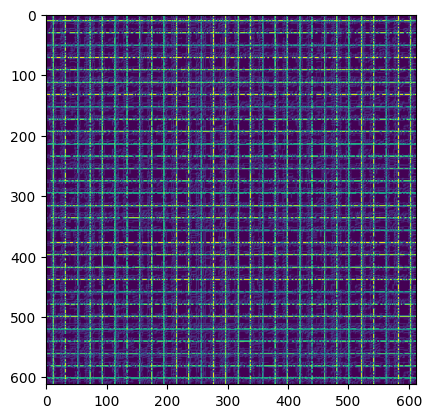

In [20]:
# 梯度幅度
magnitude = np.sqrt(Gx_1 + Gy_1)
print(np.unique(magnitude))
print(magnitude)
plt.imshow(magnitude)

[ 0.     1.     1.414  2.     2.236  2.828  3.     3.162  4.     4.125
  4.242  4.473  5.     5.098  5.656  5.746  5.832  6.     6.082  6.324
  6.402  6.48   7.     7.07   7.21   7.55   7.617  8.     8.06   8.125
  8.25   8.305  8.484  8.55   8.6    8.945  9.     9.055  9.164  9.44
  9.484  9.85   9.9   10.    10.05  10.195 10.25  10.3   10.63  10.68
 10.77  11.    11.05  11.31  11.36  11.4   11.49  11.53  11.664 11.7
 11.75  12.    12.04  12.086 12.164 12.37  12.41  12.65  12.69  12.73
 12.805 12.84  12.96  13.    13.04  13.305 13.34  13.414 13.6   13.64
 13.89  13.93  14.    14.04  14.14  14.18  14.21  14.42  14.45  14.49
 14.56  14.734 14.766 15.    15.03  15.1   15.13  15.234 15.266 15.3
 15.52  15.555 15.62  15.78  15.81 ]
[[1.414 1.    1.    ... 1.    1.    1.   ]
 [1.    0.    0.    ... 0.    0.    0.   ]
 [1.    0.    0.    ... 0.    0.    0.   ]
 ...
 [1.    1.    2.    ... 2.    2.    0.   ]
 [1.    1.    3.    ... 0.    0.    0.   ]
 [1.    0.    0.    ... 0.    0.    0.   ]

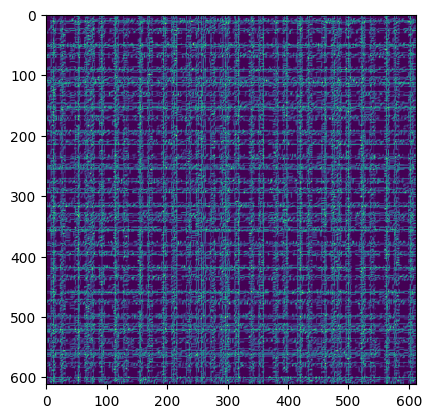

In [21]:
# 梯度幅度
magnitude = np.sqrt(Gx_1**2 + Gy_1**2)
print(np.unique(magnitude))
print(magnitude)
plt.imshow(magnitude)

# 计算梯度方向

In [22]:
np.arctan(Gx_1 / Gy_1)

C:\Users\Frostbite\AppData\Local\Temp\ipykernel_16244\2521671915.py:1: RuntimeWarning: divide by zero encountered in divide
  np.arctan(Gx_1 / Gy_1)
C:\Users\Frostbite\AppData\Local\Temp\ipykernel_16244\2521671915.py:1: RuntimeWarning: invalid value encountered in divide
  np.arctan(Gx_1 / Gy_1)


array([[0.78539816, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.57079633,        nan,        nan, ...,        nan,        nan,
               nan],
       [1.57079633,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [1.57079633, 0.        , 0.        , ..., 1.57079633, 1.57079633,
               nan],
       [1.57079633, 0.        , 0.        , ...,        nan,        nan,
               nan],
       [1.57079633,        nan,        nan, ...,        nan,        nan,
               nan]])

In [23]:
np.arctan(Gy_1 / Gx_1)

C:\Users\Frostbite\AppData\Local\Temp\ipykernel_16244\4182290492.py:1: RuntimeWarning: divide by zero encountered in divide
  np.arctan(Gy_1 / Gx_1)
C:\Users\Frostbite\AppData\Local\Temp\ipykernel_16244\4182290492.py:1: RuntimeWarning: invalid value encountered in divide
  np.arctan(Gy_1 / Gx_1)


array([[0.78539816, 1.57079633, 1.57079633, ..., 1.57079633, 1.57079633,
        1.57079633],
       [0.        ,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.        ,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.        , 1.57079633, 1.57079633, ..., 0.        , 0.        ,
               nan],
       [0.        , 1.57079633, 1.57079633, ...,        nan,        nan,
               nan],
       [0.        ,        nan,        nan, ...,        nan,        nan,
               nan]])

In [24]:
# 使用NumPy的atan2函数计算梯度方向
# atan2函数会为每个对应的Gx和Gy值返回一个角度。
# 如果Gx为0而Gy不为0，那么返回的角度将是90度或270度（取决于Gy的符号），这表示梯度方向是垂直的。
# 如果Gx和Gy都为0，则atan2将返回0，表示没有边缘。
Gx = np.array([0, 1, 1, 0, -1, -1, -1,  0,  1])
Gy = np.array([0, 0, 1, 1,  1,  0, -1, -1, -1])

# 使用NumPy的atan2函数计算梯度方向
theta = np.arctan2(Gy, Gx)
theta

array([ 0.        ,  0.        ,  0.78539816,  1.57079633,  2.35619449,
        3.14159265, -2.35619449, -1.57079633, -0.78539816])

In [25]:
# 将弧度转换为度
theta_degrees = np.degrees(theta)
theta_degrees

array([   0.,    0.,   45.,   90.,  135.,  180., -135.,  -90.,  -45.])

In [26]:
theta = np.arctan2(Gx_1, Gy_1)
print(np.unique(theta))
theta

[0.       0.00392  0.004486 ... 1.565    1.566    1.57    ]


array([[0.785, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.57 , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.57 , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [1.57 , 0.   , 0.   , ..., 1.57 , 1.57 , 0.   ],
       [1.57 , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.57 , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]], dtype=float16)

In [27]:
theta_degrees = np.degrees(theta)
print(np.unique(theta_degrees))
theta_degrees

[ 0.      0.2247  0.257  ... 89.7    89.75   90.    ]


array([[45.,  0.,  0., ...,  0.,  0.,  0.],
       [90.,  0.,  0., ...,  0.,  0.,  0.],
       [90.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [90.,  0.,  0., ..., 90., 90.,  0.],
       [90.,  0.,  0., ...,  0.,  0.,  0.],
       [90.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float16)

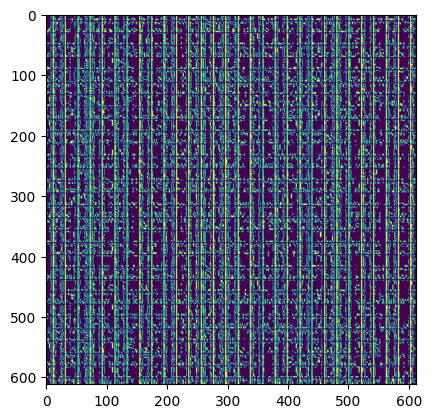

In [28]:
plt.imshow(theta_degrees)